In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

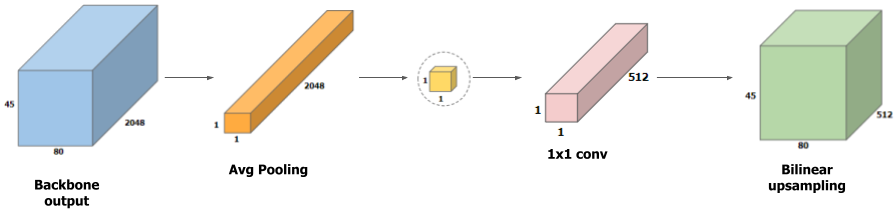

In [2]:
class pyramid_pooling_module(nn.Module):
    def __init__(self, in_channels, out_channels, bin_sizes):
        super(pyramid_pooling_module, self).__init__()
        # Pyramid Pooling Module for each layer
        self.pyramid_pool_layers = []
        for bin_sz in bin_sizes:
            self.pyramid_pool_layers.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=bin_sz),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        self.pyramid_pool_layers = nn.ModuleList(self.pyramid_pool_layers)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for layer in self.pyramid_pool_layers:
            out.append(F.interpolate(layer(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

In [3]:
ppm_test_input = torch.Tensor(2, 2048, 45, 80)
ppm_test = pyramid_pooling_module(in_channels=2048, out_channels=512, bin_sizes=[1])
ppm_test(ppm_test_input).shape

torch.Size([2, 2560, 45, 80])

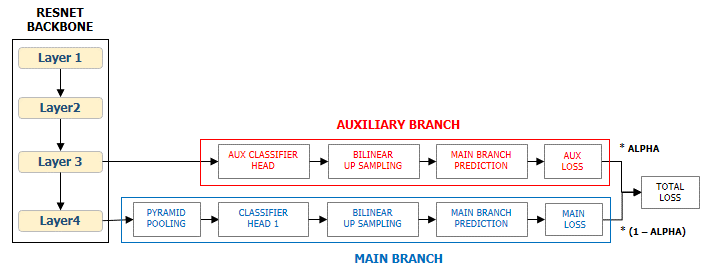

In [4]:
class auxiliary_branch(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(auxiliary_branch, self).__init__()
        self.aux = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=256,
                      kernel_size=3, stride=1,
                      padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=num_classes,
                      kernel_size=3, stride=1,
                      padding=0, bias=False),
        )

    def forward(self, x):
        return F.interpolate(input=self.aux(x), size=(360, 640),
                             mode='bilinear', align_corners=True)

In [5]:
aux_test_input = torch.Tensor(2, 1024, 45, 80)
aux_branch_test = auxiliary_branch(in_channels=1024, num_classes=3)
aux_branch_test(aux_test_input).shape

torch.Size([2, 3, 360, 640])

In [6]:
import segmentation_models_pytorch as smp

class pspnet_loss(nn.Module):
    def __init__(self, num_classes, aux_weight=0.4):
        super(pspnet_loss, self).__init__()
        self.aux_weight = aux_weight
        self.criterion = smp.losses.DiceLoss(mode='multiclass', classes=np.arange(num_classes).tolist(),
                                             log_loss=True, smooth=1.0)

    def forward(self, preds, targets):
        if isinstance(preds, dict):
            main_loss = self.criterion(preds['main'], targets)
            aux_loss = self.criterion(preds['aux'], targets)
            return (1 - self.aux_weight) * main_loss + self.aux_weight * aux_loss
        else:
            return self.criterion(preds, targets)

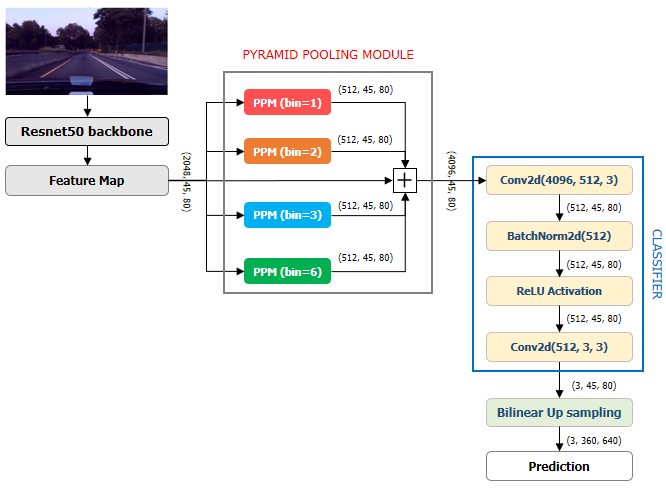

In [7]:
import torchvision.models as models

class PSPNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_aux=False):
        super(PSPNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Backbone
        self.backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT,
                                         replace_stride_with_dilation=[False, True, True])
        self.initial = nn.Sequential(*list(self.backbone.children())[:4])
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4

        # Pyramid Pooling Module
        ppm_in_channels = int(self.backbone.fc.in_features)
        self.ppm = pyramid_pooling_module(in_channels=ppm_in_channels,
                                     out_channels=512, bin_sizes=[1,2,3,6])

        # classifier head
        self.cls = nn.Sequential(
            nn.Conv2d(ppm_in_channels * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(512,  self.num_classes, kernel_size=1)
        )

        # Main branch = PPM + Classifier
        self.main_branch = nn.Sequential(self.ppm, self.cls)

        # Auxiliary branch
        self.use_aux = False
        if self.training and use_aux:
            self.use_aux = True
            self.aux_branch = nn.Sequential(
                nn.Conv2d( int(ppm_in_channels / 2) , 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.1),
                nn.Conv2d(256, self.num_classes, kernel_size=1)
            )

    def forward(self, x):
        input_size = x.size()[2:]

        # Backbone
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_aux = self.layer3(x)
        x = self.layer4(x_aux)

        # Main branch
        main_out = self.main_branch(x)
        main_out = F.interpolate(main_out, size=input_size, mode='bilinear')

        # Auxiliary branch
        if self.training and self.use_aux:
            aux_out = self.aux_branch(x_aux)
            aux_out = F.interpolate(aux_out, size=input_size, mode='bilinear')
            output = {"main": main_out, "aux": aux_out}
            return output

        return main_out

In [8]:
import numpy as np

images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")

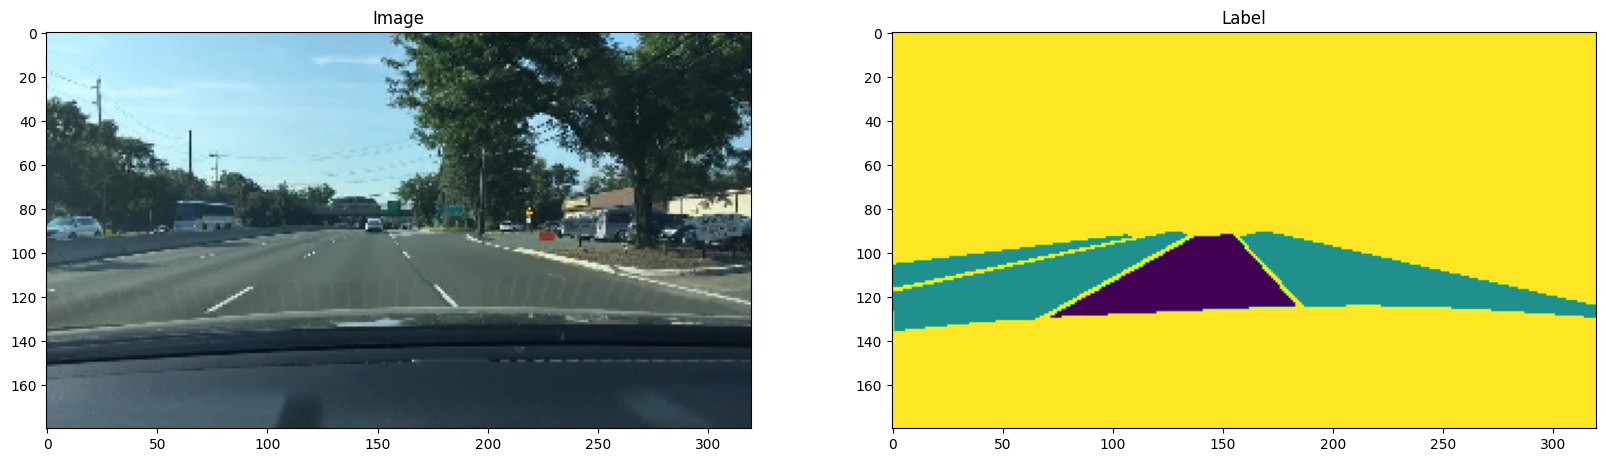

In [9]:
import matplotlib.pyplot as plt

_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
idx=150
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

In [10]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


In [11]:
from collections import namedtuple

# Each label is a tuple with name, class id, and color
Label = namedtuple("Label", ["name", "id", "color"])
drivables = [
             Label("direct", 0, (171, 44, 236)),      # purple
             Label("alternative", 1, (86, 211, 19)),  # green
             Label("background", 2, (0, 0, 0)),       # black
            ]

train_id_to_color = [c.color for c in drivables if (c.id != -1 and c.id != 255)]
train_id_to_color = np.array(train_id_to_color)
print(f"train_id_to_color: {train_id_to_color}")

train_id_to_color: [[171  44 236]
 [ 86 211  19]
 [  0   0   0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


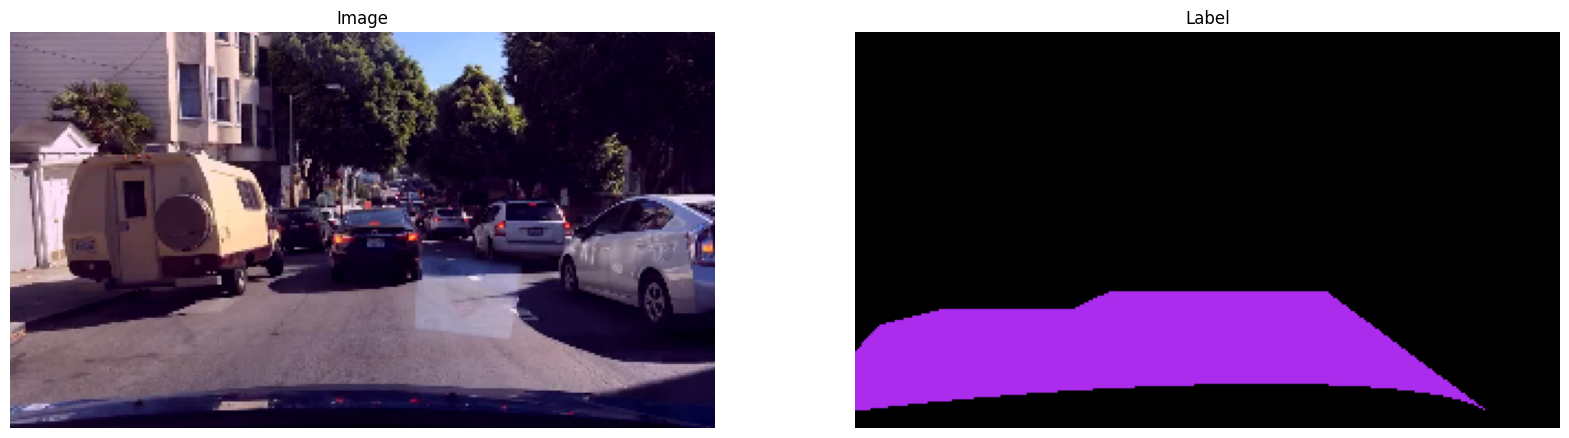

In [12]:
from utils import inverse_transform#, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
_, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image)
axes[0].set_title("Image")
axes[0].axis('off')
axes[1].imshow(train_id_to_color[label])
axes[1].set_title("Label")
axes[1].axis('off')
plt.show()

In [13]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function
from utils import pspnet_loss

Starting 1 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.17it/s]


Epoch: 1, trainLoss:0.63331, validationLoss:0.40081, meanIoU: 0.65
Starting 2 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.15it/s]


Epoch: 2, trainLoss:0.28618, validationLoss:0.35029, meanIoU: 0.69
Starting 3 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.07it/s]


Epoch: 3, trainLoss:0.17432, validationLoss:0.34871, meanIoU: 0.70
Starting 4 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 4, trainLoss:0.12502, validationLoss:0.31186, meanIoU: 0.72
Starting 5 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.14it/s]


Epoch: 5, trainLoss:0.10415, validationLoss:0.34301, meanIoU: 0.71
Starting 6 epoch ...


100%|██████████| 138/138 [00:32<00:00,  4.20it/s]


Epoch: 6, trainLoss:0.12174, validationLoss:0.35393, meanIoU: 0.71
Starting 7 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.13it/s]


Epoch: 7, trainLoss:0.13282, validationLoss:0.37564, meanIoU: 0.72
Starting 8 epoch ...


100%|██████████| 138/138 [00:32<00:00,  4.20it/s]


Epoch: 8, trainLoss:0.17143, validationLoss:0.54367, meanIoU: 0.61
Starting 9 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.14it/s]


Epoch: 9, trainLoss:0.16859, validationLoss:0.42344, meanIoU: 0.70
Starting 10 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.09it/s]


Epoch: 10, trainLoss:0.13888, validationLoss:0.32127, meanIoU: 0.74
Starting 11 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.14it/s]


Epoch: 11, trainLoss:0.11013, validationLoss:0.34000, meanIoU: 0.76
Starting 12 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.15it/s]


Epoch: 12, trainLoss:0.10116, validationLoss:0.34970, meanIoU: 0.74
Starting 13 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.18it/s]


Epoch: 13, trainLoss:0.10613, validationLoss:0.39549, meanIoU: 0.73
Starting 14 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.10it/s]


Epoch: 14, trainLoss:0.30801, validationLoss:0.46140, meanIoU: 0.65
Starting 15 epoch ...


100%|██████████| 138/138 [00:34<00:00,  4.04it/s]


Epoch: 15, trainLoss:0.30637, validationLoss:0.39221, meanIoU: 0.69
Starting 16 epoch ...


100%|██████████| 138/138 [00:34<00:00,  4.06it/s]


Epoch: 16, trainLoss:0.21962, validationLoss:0.36561, meanIoU: 0.71
Starting 17 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.76it/s]


Epoch: 17, trainLoss:0.15666, validationLoss:0.39132, meanIoU: 0.72
Starting 18 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.81it/s]


Epoch: 18, trainLoss:0.13932, validationLoss:0.33873, meanIoU: 0.74
Starting 19 epoch ...


100%|██████████| 138/138 [00:32<00:00,  4.23it/s]


Epoch: 19, trainLoss:0.11684, validationLoss:0.34769, meanIoU: 0.74
Starting 20 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.10it/s]


Epoch: 20, trainLoss:0.11595, validationLoss:0.42290, meanIoU: 0.73
Starting 21 epoch ...


100%|██████████| 138/138 [00:34<00:00,  4.06it/s]


Epoch: 21, trainLoss:0.09535, validationLoss:0.32221, meanIoU: 0.75
Starting 22 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.11it/s]


Epoch: 22, trainLoss:0.07965, validationLoss:0.30650, meanIoU: 0.76
Starting 23 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.15it/s]


Epoch: 23, trainLoss:0.07573, validationLoss:0.31954, meanIoU: 0.76
Starting 24 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.17it/s]


Epoch: 24, trainLoss:0.06700, validationLoss:0.30046, meanIoU: 0.76
Starting 25 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.06it/s]


Epoch: 25, trainLoss:0.05914, validationLoss:0.28815, meanIoU: 0.77
Starting 26 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 26, trainLoss:0.05391, validationLoss:0.30780, meanIoU: 0.76
Starting 27 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.15it/s]


Epoch: 27, trainLoss:0.04982, validationLoss:0.29356, meanIoU: 0.76
Starting 28 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.82it/s]


Epoch: 28, trainLoss:0.04640, validationLoss:0.30131, meanIoU: 0.76
Starting 29 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 29, trainLoss:0.04325, validationLoss:0.30531, meanIoU: 0.77
Starting 30 epoch ...


100%|██████████| 138/138 [00:39<00:00,  3.49it/s]


Epoch: 30, trainLoss:0.04086, validationLoss:0.26249, meanIoU: 0.77
Starting 31 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.79it/s]


Epoch: 31, trainLoss:0.03909, validationLoss:0.26397, meanIoU: 0.77
Starting 32 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.77it/s]


Epoch: 32, trainLoss:0.03725, validationLoss:0.26265, meanIoU: 0.77
Starting 33 epoch ...


100%|██████████| 138/138 [00:36<00:00,  3.77it/s]


Epoch: 33, trainLoss:0.03532, validationLoss:0.25381, meanIoU: 0.77
Starting 34 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 34, trainLoss:0.03395, validationLoss:0.26323, meanIoU: 0.77
Starting 35 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 35, trainLoss:0.03242, validationLoss:0.24926, meanIoU: 0.77
Starting 36 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 36, trainLoss:0.03103, validationLoss:0.26038, meanIoU: 0.77
Starting 37 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.17it/s]


Epoch: 37, trainLoss:0.02999, validationLoss:0.25293, meanIoU: 0.77
Starting 38 epoch ...


100%|██████████| 138/138 [00:32<00:00,  4.20it/s]


Epoch: 38, trainLoss:0.02883, validationLoss:0.24997, meanIoU: 0.77
Starting 39 epoch ...


100%|██████████| 138/138 [00:34<00:00,  4.01it/s]


Epoch: 39, trainLoss:0.02763, validationLoss:0.25674, meanIoU: 0.77
Starting 40 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.08it/s]


Epoch: 40, trainLoss:0.02666, validationLoss:0.25905, meanIoU: 0.77
Starting 41 epoch ...


100%|██████████| 138/138 [00:34<00:00,  4.04it/s]


Epoch: 41, trainLoss:0.02597, validationLoss:0.25775, meanIoU: 0.77
Starting 42 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.13it/s]


Epoch: 42, trainLoss:0.02537, validationLoss:0.25441, meanIoU: 0.77
Starting 43 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 43, trainLoss:0.02431, validationLoss:0.25496, meanIoU: 0.77
Starting 44 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.16it/s]


Epoch: 44, trainLoss:0.02324, validationLoss:0.25478, meanIoU: 0.77
Starting 45 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.15it/s]


Epoch: 45, trainLoss:0.02239, validationLoss:0.25520, meanIoU: 0.77
Starting 46 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.17it/s]


Epoch: 46, trainLoss:0.02191, validationLoss:0.25488, meanIoU: 0.77
Starting 47 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.18it/s]


Epoch: 47, trainLoss:0.02167, validationLoss:0.25428, meanIoU: 0.77
Starting 48 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.17it/s]


Epoch: 48, trainLoss:0.02153, validationLoss:0.25360, meanIoU: 0.77
Starting 49 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.18it/s]


Epoch: 49, trainLoss:0.02141, validationLoss:0.25311, meanIoU: 0.77
Starting 50 epoch ...


100%|██████████| 138/138 [00:33<00:00,  4.17it/s]


Epoch: 50, trainLoss:0.02138, validationLoss:0.25311, meanIoU: 0.77


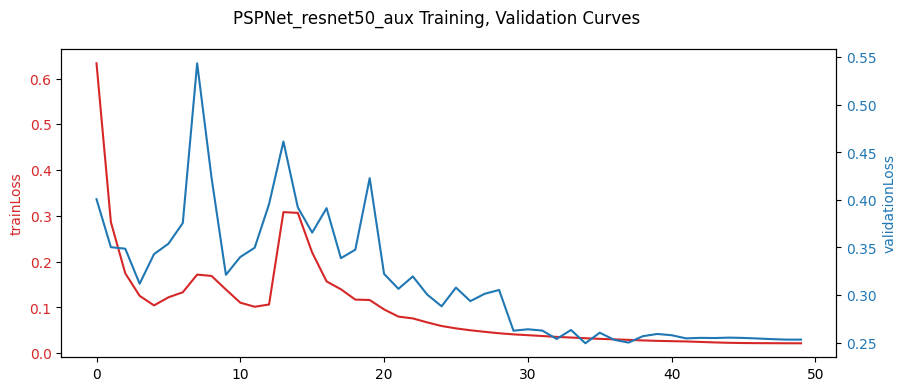

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODEL HYPERPARAMETERS
N_EPOCHS = 50
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'PSPNet_resnet50_aux'

output_path = 'dataset'

torch.cuda.empty_cache()

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = pspnet_loss(num_classes = NUM_CLASSES, aux_weight=0.4)

# create model, optimizer, lr_scheduler and pass to training function
model = PSPNet(in_channels=3, num_classes=NUM_CLASSES, use_aux=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR, weight_decay=1e-4, betas=(0.9, 0.999), amsgrad=True)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS, steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

## Run Train/Evaluate Function
_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

In [28]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 69/69 [00:17<00:00,  3.93it/s]


Model has 0.7883911486867917 mean IoU in test set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


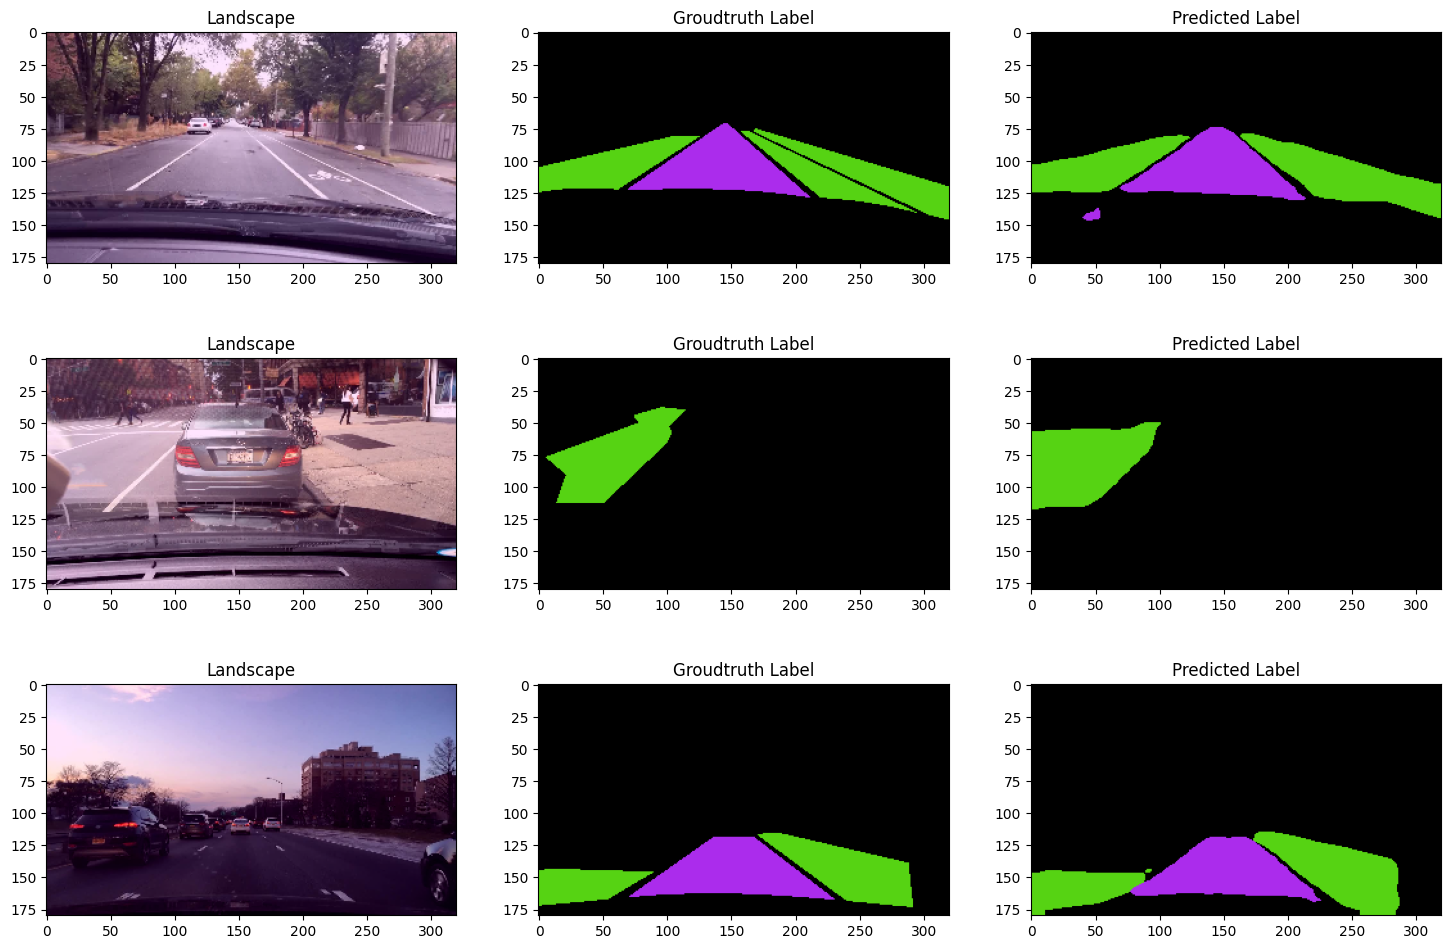

In [29]:
from utils import visualize_predictions

num_test_samples = 3
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

In [32]:
from utils import predict_video

model.cpu()

predict_video(model, "PSP50epochs", "highway_1241_376.avi", "segmentation", 1241, 376, "cpu", train_id_to_color)

100%|██████████| 1170/1170 [1:27:15<00:00,  4.48s/it]
